# Tarea 4 
# GradCAM: Mapas de Activación por Clases Pesadas por Gradientes
## Aprendizaje Automático I
### Esteban Reyes Saldaña

**Descripción**.  Implementar **GradCAM** en la red de la tarea 3 que implementó para clasificación de neumonías en Kaggle https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia Utilizando la red entrenada (guardada en un archivo) y basado en los ejemplos de las notas en https://www.cimat.mx/~mrivera/cursos/aprendizaje_profundo/GradCAM/GradCAM.html implemente GradCAM.Luego haga inferencia (predicción de la clase) de una serie de imágenes y muestre los mapas de activación para las imágenes analizadas.

In [316]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.transform import resize
from PIL import Image
import tensorflow as tf
import tensorflow.keras as keras

# Red Entrenada en la Tarea 3

In [317]:
# Conservo la mejor versión del modelo
'''
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

filepath   = base_dir + 'weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 2, save_best_only = True)
'''

"\nfrom keras.callbacks import ReduceLROnPlateau , ModelCheckpoint\n\nfilepath   = base_dir + 'weights.hdf5'\ncheckpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 2, save_best_only = True)\n"

In [318]:
'''
model.compile(loss      = 'binary_crossentropy',
              optimizer = keras.optimizers.Nadam(lr=2e-5), #optimizers.RMSprop(lr=2e-5),
              # List of metrics to monitor
              metrics   = ['acc'])

#model.reset_states()

import time
tstart = time.time()


history = model.fit_generator(train_generator,
                              steps_per_epoch  = train_generator.samples // batch_size,      # Aseguro que tenga suficietes datos
                              epochs           = 20,
                              validation_data  = validation_generator,
                              validation_steps = validation_generator.samples // batch_size, # Aseguro que tenga suficietes datos
                              callbacks=[checkpoint],                                        # Logs
                              verbose = 1)                                                   # Veo una línea por época

print('seconds=', time.time()-tstart)
'''

"\nmodel.compile(loss      = 'binary_crossentropy',\n              optimizer = keras.optimizers.Nadam(lr=2e-5), #optimizers.RMSprop(lr=2e-5),\n              # List of metrics to monitor\n              metrics   = ['acc'])\n\n#model.reset_states()\n\nimport time\ntstart = time.time()\n\n\nhistory = model.fit_generator(train_generator,\n                              steps_per_epoch  = train_generator.samples // batch_size,      # Aseguro que tenga suficietes datos\n                              epochs           = 20,\n                              validation_data  = validation_generator,\n                              validation_steps = validation_generator.samples // batch_size, # Aseguro que tenga suficietes datos\n                              callbacks=[checkpoint],                                        # Logs\n                              verbose = 1)                                                   # Veo una línea por época\n\nprint('seconds=', time.time()-tstart)\n"

# Carga de Modelo

In [319]:
base_model = keras.models.load_model('/content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/m1_trial.hdf5')

In [320]:
base_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Visualización de primer bloque de la Red

In [321]:
base_model.get_layer('vgg16').summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Carga de imágenes de validación

In [322]:
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
from keras.applications.imagenet_utils import preprocess_input

val_dir = '/content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/val'

train_datagen = ImageDataGenerator(#rescale           = 1./255,
                                   preprocessing_function=preprocess_input,
                                   rotation_range    = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range= 0.2,
                                   shear_range       = 0.2,
                                   zoom_range        = 0.2,
                                   horizontal_flip   = True,
                                   fill_mode         = 'constant',  #'nearest')
                                   cval              = 0)

val_generator = train_datagen.flow_from_directory(
                        val_dir,                # directorio con datos de entrenamiento
                        target_size= (150, 150),  # tamaño de la imágenes 
                        shuffle    = False,
                        class_mode = 'binary')    # para clasificación binaria

Found 16 images belonging to 2 classes.


In [323]:
# Obtengo imagenes y etiquetas
imgs, lbls = next(val_generator)

In [324]:
imgs[0].shape

(150, 150, 3)

# GradCam

In [325]:
last_conv_layer_name   = 'block5_conv3'
classifier_layer_names =  ['block5_pool', 'flatten_7', 'dense_20', 'dense_21']

In [326]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # Modelo que mapea la imagen de entrada a la capa convolucional última,
    # donde se calculará la activación
    last_conv_layer  = model.get_layer('vgg16').get_layer(last_conv_layer_name)
    conv_model       = keras.Model(model.get_layer('vgg16').inputs, last_conv_layer.output)
    # Modelo que mapea las activaciones a la salida final
    classifier_input = keras.Input(shape = last_conv_layer.output.shape[1:])
    x = classifier_input

    x = model.get_layer('vgg16').get_layer(classifier_layer_names[0])(x)

    for layer_name in classifier_layer_names[1:]:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Cálculo del gradiente la salida  del modelo clasificador respecto a     
    with tf.GradientTape() as tape:
        
        # Calcula activacion del modelo base convolucional
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Calcula la predicción con modelo clasificador, para la clase mas probable
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]

    # Obtenemos el gradiente en la capa final clasificadora con respecto a
    # la salida del modelo base convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vector de pesos: medias del gradiente por capas,
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # salida de la última capa convolucional
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    # saliencia es la respuesta promedio de la última capa convolucional
    saliency = np.mean(last_conv_layer_output, axis=-1)
    saliency = np.maximum(saliency, 0) / np.max(saliency)
    
    # Multiplicación de cada canal por el vector de pesos
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # Heatmap: promedio de cada canal por su peso
    grad_cam = np.mean(last_conv_layer_output, axis=-1)
    grad_cam = np.maximum(grad_cam, 0) / np.max(grad_cam)
    
    return grad_cam, saliency

In [368]:
# Generate class activation heatmap
grad_cam, saliency = make_gradcam_heatmap(imgs[7:8,:,:,:], base_model, last_conv_layer_name, classifier_layer_names)

tf.Tensor(0, shape=(), dtype=int64)


In [369]:
def show_hotmap (img, heatmap, title='Heatmap', alpha=0.6, cmap='jet', axisOnOff='off'):
    '''
    img     :    Image
    heatmap :    2d narray
    '''
    resized_heatmap=resize(heatmap, img.size)
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(resized_heatmap, alpha=alpha, cmap=cmap)
    plt.axis(axisOnOff)
    plt.title(title)
    plt.show()

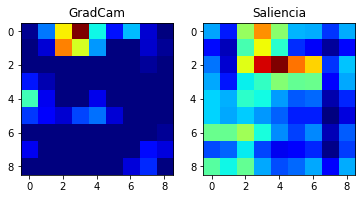

In [370]:
plt.subplot(121)
plt.imshow(grad_cam, 'jet')
plt.title('GradCam')
plt.subplot(122)
plt.imshow(saliency, 'jet')
plt.title('Saliencia')
plt.show()

In [371]:
def get_img_array(img_path, img_size):
    img = Image.open(img_path)
    
    rgb_im = img.convert('RGB')
    
    rgb_im = rgb_im.resize(size = img_size)
    print(f'format: {rgb_im.format}, shape: {rgb_im.size}, mode: {rgb_im.mode}')
    img_array = np.array(img).astype('float32')
    img_array = np.expand_dims(img_array, axis=0)
    return rgb_im, img_array

In [372]:
filename = '/content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'


format: None, shape: (150, 150), mode: RGB


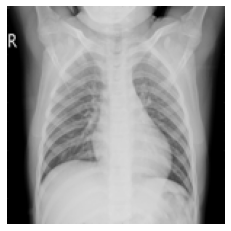

In [345]:
# load and show an image with Pillow

scale=1

img_size  = (150,150,3)

img,img_array =  get_img_array(img_path = filename,    
                               img_size = img_size[:2])

img_array = img_array/scale
plt.imshow(img)
plt.axis('off')
plt.show()

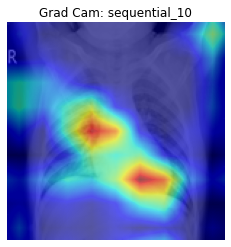

In [346]:
show_hotmap(img = img, heatmap = grad_cam, title=f'Grad Cam: {base_model.name}')


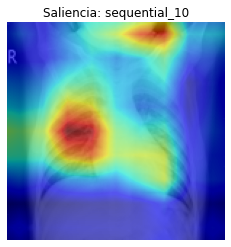

In [347]:
show_hotmap(img = img, heatmap=saliency, title=f'Saliencia: {base_model.name}')


In [ ]:
y = base_model.predict_classes(imgs)
# show the inputs and predicted outputs
for i in range(len(imgs)):
	print("X=%i, Predicted=%s" % (lbls[i], y[i]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


X=0, Predicted=[1]
X=0, Predicted=[0]
X=0, Predicted=[0]
X=0, Predicted=[1]
X=0, Predicted=[0]
X=0, Predicted=[0]
X=0, Predicted=[0]
X=0, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[0]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[0]
X=1, Predicted=[1]


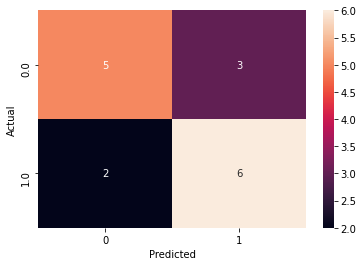

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    lbls,
        'y_Predicted': y[:,0]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

**Conclusiones**. GradCam muestra el mapa de activación para la clase seleccionada, para nuestra configuración, se seleccionó la clase de mayor probabilidad. En tanto la saliencia muestra los mapas de calor para las clases mas probables. 

Se observó además que a pesar de haber obtenido un buen rendimiento en el conjunto de test, el conjunto de validación muestra falsos negativos.